<a href="https://colab.research.google.com/github/SimranKaur-23/Bitcoin-Price-Prediction/blob/main/BitcoinpricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
import tensorflow as tf


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [ ]:
%matplotlib inline
from pylab import rcParams
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv('/content/BTC-USD (1).csv', date_parser= True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2448,2021-05-31,35658.593750,37468.250000,34241.945313,37332.855469,37332.855469,3.900985e+10
2449,2021-06-01,37293.792969,37896.734375,35787.085938,36684.925781,36684.925781,3.463942e+10
2450,2021-06-02,36699.921875,38231.339844,35966.308594,37575.179688,37575.179688,3.307087e+10
2451,2021-06-03,37599.410156,39478.953125,37243.972656,39208.765625,39208.765625,3.546075e+10
2452,2021-06-04,39149.171875,39149.171875,36364.558594,36451.542969,36451.542969,3.870829e+10


In [ ]:
df.shape

(2453, 7)

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2453 entries, 0 to 2452
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2453 non-null   object 
 1   Open       2449 non-null   float64
 2   High       2449 non-null   float64
 3   Low        2449 non-null   float64
 4   Close      2449 non-null   float64
 5   Adj Close  2449 non-null   float64
 6   Volume     2449 non-null   float64
dtypes: float64(6), object(1)
memory usage: 153.3+ KB


In [ ]:
df["Date"]= pd.to_datetime(df["Date"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2453 entries, 0 to 2452
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2453 non-null   datetime64[ns]
 1   Open       2449 non-null   float64       
 2   High       2449 non-null   float64       
 3   Low        2449 non-null   float64       
 4   Close      2449 non-null   float64       
 5   Adj Close  2449 non-null   float64       
 6   Volume     2449 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 153.3 KB


Text(0, 0.5, 'Close Price (USD)')

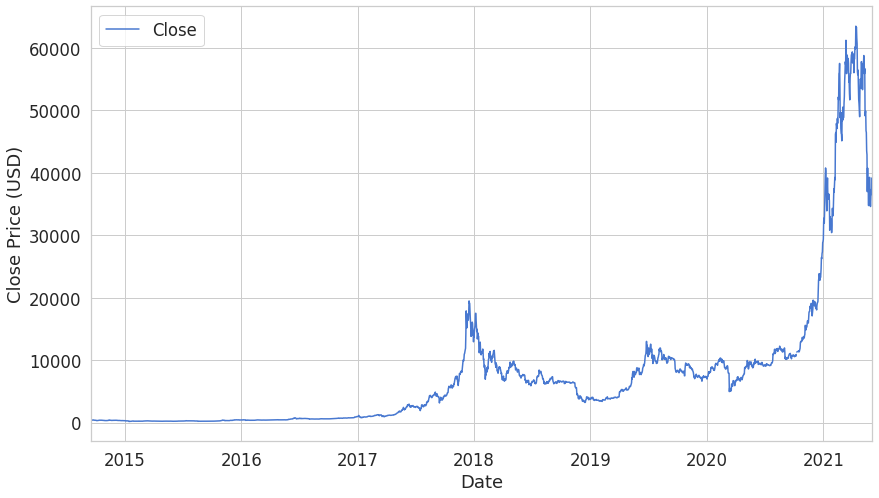

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [ ]:
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


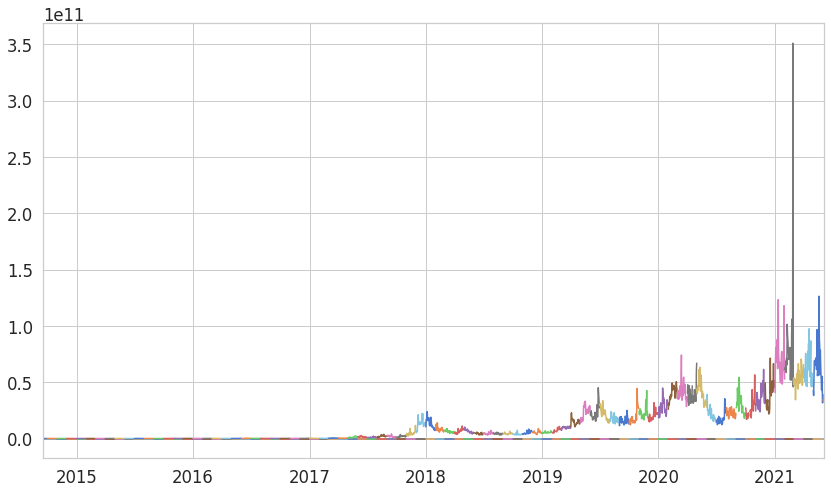

In [ ]:
df.resample('M').plot(x='Close')
#plt.legend()
plt.show()

In [ ]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train.shape

(2231, 99, 1)

In [ ]:
X_test.shape

(118, 99, 1)

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True,
                                  input_shape=(WINDOW_SIZE, X_train.shape[-1]))))
model.add(Dropout(rate = DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [ ]:
#training
BATCH_SIZE = 64

model.compile(loss='mean_squared_error',optimizer='adam')

history = model.fit(X_train,y_train,epochs=50,batch_size=BATCH_SIZE,shuffle=False,validation_split=0.1)

Epoch 1/50
32/32 [==============================] - 12s 71ms/step - loss: 0.0031 - val_loss: 0.0245
Epoch 2/50
32/32 [==============================] - 1s 43ms/step - loss: 0.0041 - val_loss: 0.0281
Epoch 3/50
32/32 [==============================] - 1s 43ms/step - loss: 0.0022 - val_loss: 0.0181
Epoch 4/50
32/32 [==============================] - 1s 43ms/step - loss: 0.0025 - val_loss: 0.0136
Epoch 5/50
32/32 [==============================] - 1s 43ms/step - loss: 0.0016 - val_loss: 0.0089
Epoch 6/50
32/32 [==============================] - 1s 42ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 7/50
32/32 [==============================] - 1s 43ms/step - loss: 0.0010 - val_loss: 0.0035
Epoch 8/50
32/32 [==============================] - 1s 42ms/step - loss: 8.2615e-04 - val_loss: 0.0038
Epoch 9/50
32/32 [==============================] - 1s 43ms/step - loss: 8.4794e-04 - val_loss: 0.0039
Epoch 10/50
32/32 [==============================] - 1s 43ms/step - loss: 4.2613e-04 - val_loss: 0.0

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 67ms/step - loss: 0.0063


0.00627444963902235

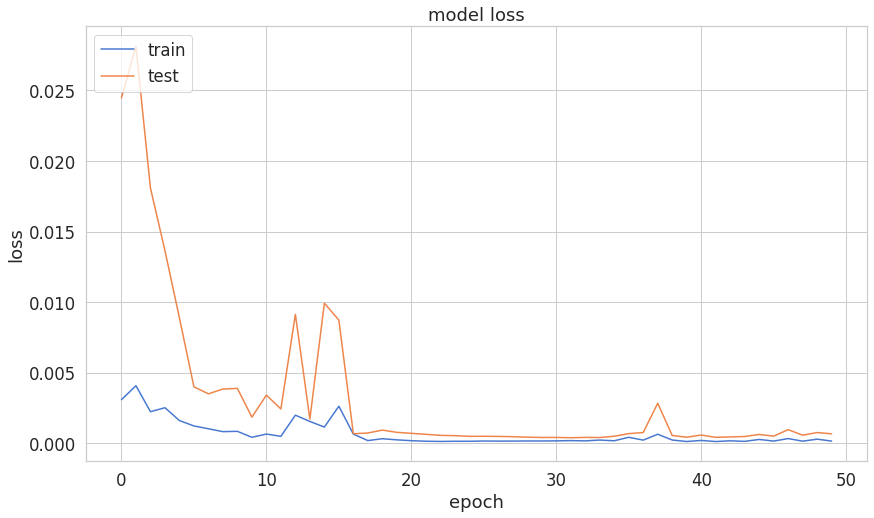

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

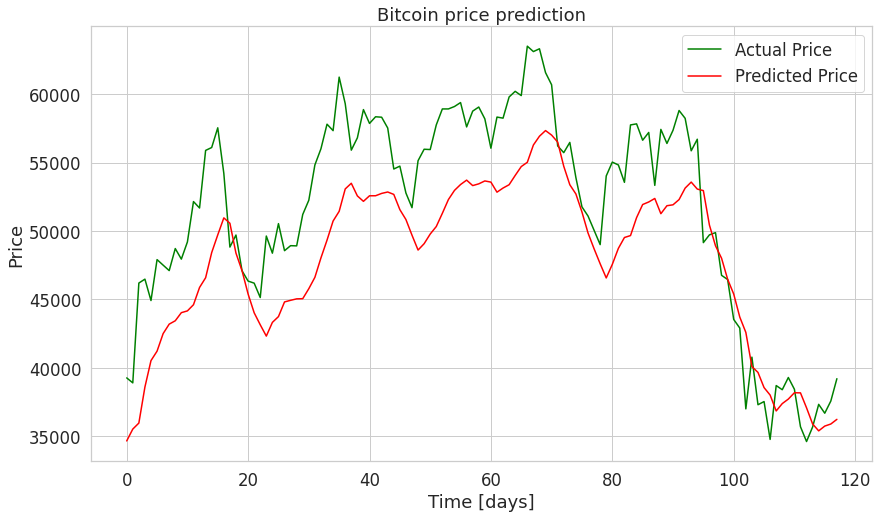

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();